# Surveying dust structure via GALEX MIS

## Learning goals

By the end of this tutorial you will be able to:

- Understand NUV and FUV images and how they are useful to study dust
- Navigate the GALEX MIS catalog
- Create a mosaic from several images

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. 

**GALEX Medium Imaging survey (MIS) background**: Single orbit exposures (1,500s) of 1000 square degrees in positions that match the Sloan Digital Sky Survey (SDSS) spectroscopic footprint. The MIS has been extended to cover the Two Degree Field Galaxy Redshift Survey (2dFGRS) and the AA-Omega (WiggleZ) project.

**Defining some terms:**

- MIVC: Molecular Intermediate Velocity Cloud.
- Intensity map: image that displays the photons per pixel per second corrected for the relative response of the instrument used. 

## Imports

- _Observations_ from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).

In [2]:
from astroquery.mast import Observations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import os
from astropy.visualization import ZScaleInterval

## Target: Draco MIVC

The objective of this tutorial is to create a mosaic of a high-latitude cloud using different images retrieved from GALEX MIS. The GALEX MIS products can be accesed through _astroquery.mast_, and we will perform a search using the galactic coordinates of some objects belonging to the Draco cloud, let's start with the coordinates that SIMBAD provides for <a href="http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%40375027&Name=NAME%20Draco%20Nebula&submit=submit">the Draco Nebula</a> (ICRS coordinates, ep = J2000): 

- Right ascension: 253.0 deg
- Declination: +61.0 deg

## GALEX MIS - Unique source query

Let's start with this one source, and see step by step how to retrieve the image from the database, first let's use the coordinates of the source to find it in the database. We will use <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">_SkyCoord_</a> to correctly characterize the units and reference frame of our source. The coordinates displayed above are expressed in degrees and are in the galactic reference frame, we can specify this by using the arguments _unit_ and _frame_ as shown below:

In [97]:
coord = SkyCoord(253.0000, +61.0, unit='deg', frame='icrs')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius=".01 deg")
data_products = Observations.get_product_list(obs)
data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str152,str9,str28,str12,str1,str3,str1,str1,str61,int64,str3,str6,int64
45112,GALEX,image,2415866739821641728,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,6889,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cnt.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cnt.fits.gz,2427899,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-exp.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-exp.fits.gz,155194,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Artifact and source star detailed info.,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flag_tbl.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flag_tbl.fits.gz,2043,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Artifact Flag image (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flags.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flags.fits.gz,16023,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Star catalog for flagging,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flagstar.fits.gz,4065,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Background subtracted intensity map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-intbgsub.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-intbgsub.fits.gz,14459176,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Time-slice count maps (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-movie.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-movie.fits.gz,2908089,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,FUV extractions using NUV positions,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-ncat.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-ncat.fits.gz,4382038,129,PUBLIC,2


In [5]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
yourProd = data_products_mrp[0]
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str152,str9,str28,str12,str1,str3,str1,str1,str61,int64,str3,str6,int64
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-fd-int.fits.gz,12208657,129,PUBLIC,2


In [6]:
table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
table

Local Path,Status,Message,URL
str73,str8,object,object
./mastDownload/GALEX/2415866877260595200/MISDR1_10131_0351-fd-int.fits.gz,COMPLETE,None,None


In [7]:
filename = table['Local Path'][0]
os.system("gunzip " + filename)

0

In [8]:
fits.info(filename[:-3])

Filename: ./mastDownload/GALEX/2415866877260595200/MISDR1_10131_0351-fd-int.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     122   (3840, 3840)   float32   


In [109]:
with fits.open(filename[:-3]) as hdulist: 
    header = hdulist[0].header
    image = hdulist[0].data

## GALEX naming convention

Before exploring the actual data retrieved from the data archive, let's focus on the name of the file, to try and understand GALEX naming conventions:

In [64]:
print(filename[41:-8])

MISDR1_10131_0351-fd-int


Let's break it down in different parts:

- MIS: Corresponds to the survey that delivered the data, in this case it referes to the Medium Imaging Survey.
- ...
- fd: The filename suffix normally beings with a string refering to the band or mode, fd means FUV direct (imaging).
- int: Intensity map (J2000)

More information about the naming convention can be found in the <a href="https://archive.stsci.edu/manuals/archive_handbook/chap4.html">MAST webpage dedicated to GALEX</a> and in <a href="http://galex.stsci.edu/doc/CTM/wiki/Public_documentation/Appendix_A.html#Direct_Imaging_Data_Products">GALEX webpage</a>.

## Include coordinates in image

The header provides us with information about the coordinates that are being represented in the image from the FITS file, key parameters for this are as follows:

- NAXIS1/2: length of data axis 1/2
- CDELT1/2: increment on 1st/2nd axis
- CRPIX1/2: reference pixel on 1st/2nd axis
- CRVAL1/2: RA/Dec at reference point

Let's display them from our header:

In [10]:
print(repr(header[3:5]))
print(repr(header[13:23]))

NAXIS1  =                 3840 / length of data axis 1                          
NAXIS2  =                 3840 / length of data axis 2                          
CDELT1  = -0.000416666666666667                                                 
CDELT2  = 0.000416666666666667                                                  
EQUINOX =                2000.                                                  
EPOCH   =                2000.                                                  
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRPIX1  =               1920.5                                                  
CRPIX2  =               1920.5                                                  
CRVAL1  =            254.10219                                                  
CRVAL2  =             61.22776                                                  


They can also be directly accessed using the keywords that we want to extract from the header:

In [11]:
print(header['NAXIS1'])

3840


Since we know the value of the RA and Dec at the reference pixels, the number of pixels and the increments on the axis, we can generate two vectors corresponding to the actual values of the RA and Dec for each pixel! Let's do that now, since we will use this later when we display our images:

In [12]:
naxis1 = header['NAXIS1']
naxis2 = header['NAXIS2']
cdelt1 = header['CDELT1']
cdelt2 = header['CDELT2']
crpix1 = header['CRPIX1']
crpix2 = header['CRPIX2']
crval1 = header['CRVAL1']
crval2 = header['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1-1)*cdelt1
# Final RA - Last Pixel 
RAf = crval1 + (crpix1-1)*cdelt1

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (crpix2-1)*cdelt2

## Display the final image

Normally when you display an image, it may look as if it was blank, let's try to directly display the image that we retrieve from the archive. The intensity maps contained in GALEX have the following units: counts pixel cm s Å. We will do this using the <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html">_imshow_ attribute</a> from _matplotlib.pyplot_:

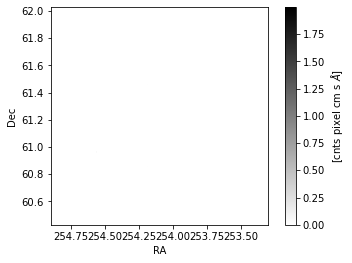

In [69]:
plt.imshow(image, extent=[RA1,RAf,Dec1,Decf], cmap='binary')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='[cnts pixel cm s $\AA$]')
plt.show()

At first glance, the image seems to be empty, however, let's change the _vmin_ and _vmax_ arguments from _imshow_ and see if we can see any difference. Since the image is 3840x3840 in size, let's only use a central smaller square to decide what limits to use. A useful resource for choosing this limits is <a href="https://docs.astropy.org/en/stable/api/astropy.visualization.ZScaleInterval.html#astropy.visualization.ZScaleInterval">_ZScaleInterval_</a>, which calculates the image values near the median image, this is particularly useful for astronomical images, which generally have a very peaked histogram which can correspond to sky backgrounds.

In [70]:
cut = image[1850:-1850,1850:-1850]
interval = ZScaleInterval(nsamples=cut.size, contrast=0.5, max_reject=0.5)
vmin, vmax = interval.get_limits(cut)

print('Limits for image: vmin = ',vmin,', vmax = ',vmax)

Limits for image: vmin =  0.0 , vmax =  0.0014790618198790054


Now let's display the image again:

_**Note**: imshow inverts the y-axis, so when we define the extent of the Declination, we should provide the limits in the reverse order as we have defined them._

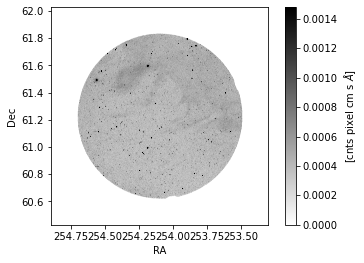

In [81]:
plt.imshow(image, extent=[RA1,RAf,Decf,Dec1], vmin=vmin, vmax=vmax, cmap='binary')
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='[cnts pixel cm s $\AA$]')
plt.show()

Great! Now we can actually see the contents of our image.

## More images

### Image 2

In [102]:
coord = SkyCoord(252.0000, +62.0, unit='deg', frame='icrs')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius="1 deg")
data_products = Observations.get_product_list(obs)
data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
45112,GALEX,image,2415866739821641728,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,6889,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cnt.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cnt.fits.gz,2427899,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-exp.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-exp.fits.gz,155194,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Artifact and source star detailed info.,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flag_tbl.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flag_tbl.fits.gz,2043,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Artifact Flag image (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flags.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flags.fits.gz,16023,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Star catalog for flagging,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flagstar.fits.gz,4065,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Background subtracted intensity map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-intbgsub.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-intbgsub.fits.gz,14459176,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Time-slice count maps (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-movie.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-movie.fits.gz,2908089,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,FUV extractions using NUV positions,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-ncat.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-ncat.fits.gz,4382038,129,PUBLIC,2


In [103]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
data_products_mrp

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-fd-int.fits.gz,12208657,129,PUBLIC,2
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-nd-int.fits.gz,16264745,129,PUBLIC,2
7421,GALEX,image,3882562612155645952,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/44813-MISGCSN2_10096_0002/d/01-main/0001-img/07-try/MISGCSN2_10096_0002-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISGCSN2_10096_0002-nd-int.fits.gz,16124613,7421,PUBLIC,2


In [104]:
yourProd1 = data_products_mrp[2]
table1 = Observations.download_products(yourProd1, mrp_only = False, cache = False) 

In [106]:
filename1 = table1['Local Path'][0]
os.system("gunzip " + filename1)

0

In [110]:
filename1 = table1['Local Path'][0]
with fits.open(filename1[:-3]) as hdulist: 
    header1 = hdulist[0].header
    image1 = hdulist[0].data

In [111]:
naxis1 = header1['NAXIS1']
naxis2 = header1['NAXIS2']
cdelt1 = header1['CDELT1']
cdelt2 = header1['CDELT2']
crpix1 = header1['CRPIX1']
crpix2 = header1['CRPIX2']
crval1 = header1['CRVAL1']
crval2 = header1['CRVAL2']

# Initial RA - Pixel 1
RA12 = crval1 - (crpix1-1)*cdelt1
# Final RA - Last Pixel 
RAf2 = crval1 + (crpix1-1)*cdelt1

# Initial Dec - Pixel 1
Dec12 = crval2 - (crpix2-1)*cdelt2
# Final Dec - Last Pixel 
Decf2 = crval2 + (crpix2-1)*cdelt2

In [142]:
cut = image1[1850:-1850,1850:-1850]
interval = ZScaleInterval(nsamples=cut.size, contrast=0.5, max_reject=0.5)
vmin1, vmax1 = interval.get_limits(cut)

print('Limits for image: vmin = ',vmin1,', vmax = ',vmax1)

Limits for image: vmin =  0.0 , vmax =  0.007628820704607638


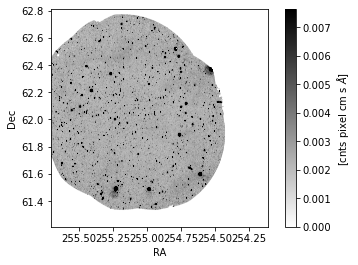

In [147]:
plt.figure()
plt.imshow(image1,extent=[RA12,RAf2,Decf2,Dec12], vmin=vmin1, vmax=vmax1, cmap='binary')
#plt.imshow(image, extent=[RA1,RAf,Decf,Dec1], vmin=vmin, vmax=vmax, cmap='binary')
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='[cnts pixel cm s $\AA$]')
plt.show()

### Image 3

In [136]:
coord = SkyCoord(253.0000, +63.0, unit='deg', frame='icrs')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius="1 deg")
data_products = Observations.get_product_list(obs)
data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
45105,GALEX,image,2415726002333286400,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-cat_mch_flagstar.fits.gz,8328,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-cnt.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-cnt.fits.gz,2337479,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-exp.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-exp.fits.gz,148291,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Artifact and source star detailed info.,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-flag_tbl.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-flag_tbl.fits.gz,2041,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Artifact Flag image (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-flags.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-flags.fits.gz,15762,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Star catalog for flagging,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-flagstar.fits.gz,5190,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Background subtracted intensity map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-intbgsub.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-intbgsub.fits.gz,14007568,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,Time-slice count maps (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-movie.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-movie.fits.gz,2671962,125,PUBLIC,2
45105,GALEX,image,2415726002333286400,FUV extractions using NUV positions,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/00-visits/0001-img/07-try/MISDR1_10031_0349_0001-fd-ncat.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10031_0349_0001-fd-ncat.fits.gz,3900790,125,PUBLIC,2


In [137]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
data_products_mrp

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
125,GALEX,image,2415726139772239872,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/01-main/0001-img/07-try/MISDR1_10031_0349-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10031_0349-fd-int.fits.gz,11863186,125,PUBLIC,2
125,GALEX,image,2415726139772239872,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03123-MISDR1_10031_0349/d/01-main/0001-img/07-try/MISDR1_10031_0349-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10031_0349-nd-int.fits.gz,17304728,125,PUBLIC,2
126,GALEX,image,2415761324144328704,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03124-MISDR1_10032_0349/d/01-main/0001-img/07-try/MISDR1_10032_0349-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10032_0349-nd-int.fits.gz,15677731,126,PUBLIC,2
7421,GALEX,image,3882562612155645952,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/44813-MISGCSN2_10096_0002/d/01-main/0001-img/07-try/MISGCSN2_10096_0002-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISGCSN2_10096_0002-nd-int.fits.gz,16124613,7421,PUBLIC,2


In [138]:
yourProd1 = data_products_mrp[0]
table1 = Observations.download_products(yourProd1, mrp_only = False, cache = False) 
table1

Local Path,Status,Message,URL
str73,str8,object,object
./mastDownload/GALEX/2415726139772239872/MISDR1_10031_0349-fd-int.fits.gz,COMPLETE,None,None


In [140]:
filename1 = table1['Local Path'][0]
os.system("gunzip " + filename1)

0

In [141]:
with fits.open(filename1[:-3]) as hdulist: 
    header2 = hdulist[0].header
    image2 = hdulist[0].data
    
naxis1 = header2['NAXIS1']
naxis2 = header2['NAXIS2']
cdelt1 = header2['CDELT1']
cdelt2 = header2['CDELT2']
crpix1 = header2['CRPIX1']
crpix2 = header2['CRPIX2']
crval1 = header2['CRVAL1']
crval2 = header2['CRVAL2']

# Initial RA - Pixel 1
RA13 = crval1 - (crpix1-1)*cdelt1
# Final RA - Last Pixel 
RAf3 = crval1 + (crpix1-1)*cdelt1

# Initial Dec - Pixel 1
Dec13 = crval2 - (crpix2-1)*cdelt2
# Final Dec - Last Pixel 
Decf3 = crval2 + (crpix2-1)*cdelt2

In [144]:
cut = image2[1850:-1850,1850:-1850]
interval = ZScaleInterval(nsamples=cut.size, contrast=0.6, max_reject=0.5)
vmin2, vmax2 = interval.get_limits(cut)

print('Limits for image: vmin = ',vmin2,', vmax = ',vmax2)

Limits for image: vmin =  0.0 , vmax =  0.0013561044873972431


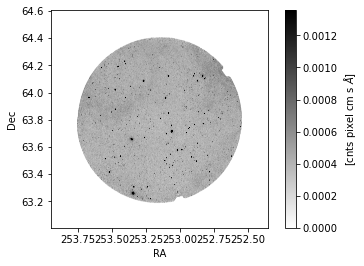

In [153]:
plt.figure()
plt.imshow(image2,extent=[RA13,RAf3,Decf3,Dec13], vmin=vmin2, vmax=vmax2, cmap='binary')
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='[cnts pixel cm s $\AA$]')
plt.show()

### Image 4

In [158]:
coord = SkyCoord(255.0000, +60.0, unit='deg', frame='icrs')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord,project='MIS',radius="1 deg")
data_products = Observations.get_product_list(obs)
data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
45112,GALEX,image,2415866739821641728,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cat_mch_flagstar.fits.gz,6889,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-cnt.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-cnt.fits.gz,2427899,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-exp.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-exp.fits.gz,155194,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Artifact and source star detailed info.,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flag_tbl.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flag_tbl.fits.gz,2043,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Artifact Flag image (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flags.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flags.fits.gz,16023,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Star catalog for flagging,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-flagstar.fits.gz,4065,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Background subtracted intensity map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-intbgsub.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-intbgsub.fits.gz,14459176,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,Time-slice count maps (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-movie.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-movie.fits.gz,2908089,129,PUBLIC,2
45112,GALEX,image,2415866739821641728,FUV extractions using NUV positions,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/00-visits/0001-img/07-try/MISDR1_10131_0351_0001-fd-ncat.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_10131_0351_0001-fd-ncat.fits.gz,4382038,129,PUBLIC,2


In [159]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
data_products_mrp

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str5,str5,str5,str19,str139,str1,str156,str9,str28,str12,str1,str3,str1,str1,str63,int64,str4,str6,int64
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-fd-int.fits.gz,12208657,129,PUBLIC,2
129,GALEX,image,2415866877260595200,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03127-MISDR1_10131_0351/d/01-main/0001-img/07-try/MISDR1_10131_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10131_0351-nd-int.fits.gz,16264745,129,PUBLIC,2
130,GALEX,image,2415902061632684032,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03128-MISDR1_10165_0351/d/01-main/0001-img/07-try/MISDR1_10165_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10165_0351-fd-int.fits.gz,11944405,130,PUBLIC,2
130,GALEX,image,2415902061632684032,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03128-MISDR1_10165_0351/d/01-main/0001-img/07-try/MISDR1_10165_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10165_0351-nd-int.fits.gz,16236104,130,PUBLIC,2
131,GALEX,image,2415937246004772864,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03129-MISDR1_10166_0351/d/01-main/0001-img/07-try/MISDR1_10166_0351-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10166_0351-fd-int.fits.gz,12602147,131,PUBLIC,2
131,GALEX,image,2415937246004772864,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03129-MISDR1_10166_0351/d/01-main/0001-img/07-try/MISDR1_10166_0351-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10166_0351-nd-int.fits.gz,17023770,131,PUBLIC,2
135,GALEX,image,2416077983493128192,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03133-MISDR1_10201_0353/d/01-main/0001-img/07-try/MISDR1_10201_0353-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10201_0353-fd-int.fits.gz,12893481,135,PUBLIC,2
135,GALEX,image,2416077983493128192,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03133-MISDR1_10201_0353/d/01-main/0001-img/07-try/MISDR1_10201_0353-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10201_0353-nd-int.fits.gz,16998435,135,PUBLIC,2
136,GALEX,image,2416113167865217024,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03134-MISDR1_10202_0353/d/01-main/0001-img/07-try/MISDR1_10202_0353-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_10202_0353-fd-int.fits.gz,12304216,136,PUBLIC,2


In [161]:
yourProd1 = data_products_mrp[4]
table1 = Observations.download_products(yourProd1, mrp_only = False, cache = False) 
table1

Local Path,Status,Message,URL
str73,str8,object,object
./mastDownload/GALEX/2415937246004772864/MISDR1_10166_0351-fd-int.fits.gz,COMPLETE,None,None


In [162]:
filename1 = table1['Local Path'][0]
os.system("gunzip " + filename1)

0

In [166]:
with fits.open(filename1[:-3]) as hdulist: 
    header3 = hdulist[0].header
    image3 = hdulist[0].data
    
naxis1 = header3['NAXIS1']
naxis2 = header3['NAXIS2']
cdelt1 = header3['CDELT1']
cdelt2 = header3['CDELT2']
crpix1 = header3['CRPIX1']
crpix2 = header3['CRPIX2']
crval1 = header3['CRVAL1']
crval2 = header3['CRVAL2']

# Initial RA - Pixel 1
RA14 = crval1 - (crpix1-1)*cdelt1
# Final RA - Last Pixel 
RAf4 = crval1 + (crpix1-1)*cdelt1

# Initial Dec - Pixel 1
Dec14 = crval2 - (crpix2-1)*cdelt2
# Final Dec - Last Pixel 
Decf4 = crval2 + (crpix2-1)*cdelt2

In [164]:
cut = image3[1850:-1850,1850:-1850]
interval = ZScaleInterval(nsamples=cut.size, contrast=0.6, max_reject=0.5)
vmin3, vmax3 = interval.get_limits(cut)

print('Limits for image: vmin = ',vmin3,', vmax = ',vmax3)

Limits for image: vmin =  0.0 , vmax =  0.0012825079379976


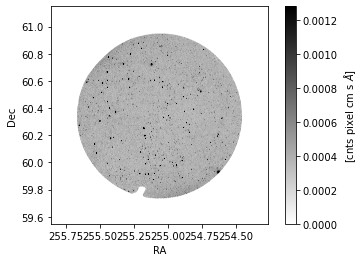

In [170]:
plt.figure()
plt.imshow(image3,extent=[RA14,RAf4,Decf4,Dec14], vmin=vmin3, vmax=vmax3, cmap='binary')
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='[cnts pixel cm s $\AA$]')
plt.show()

## Final mosaic

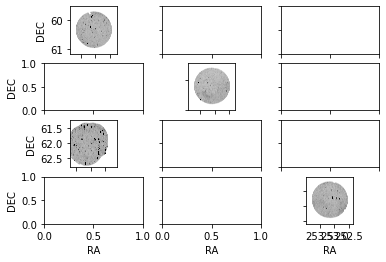

In [175]:
fig, axs = plt.subplots(4, 3)
axs[0, 0].imshow(image3,extent=[RA14,RAf4,Decf4,Dec14], vmin=vmin3, vmax=vmax3, cmap='binary')
axs[2, 0].imshow(image1,extent=[RA12,RAf2,Decf2,Dec12], vmin=vmin1, vmax=vmax1, cmap='binary')
axs[1, 1].imshow(image, extent=[RA1,RAf,Decf,Dec1], vmin=vmin, vmax=vmax, cmap='binary')
axs[3, 2].imshow(image2,extent=[RA13,RAf3,Decf3,Dec13], vmin=vmin2, vmax=vmax2, cmap='binary')

for ax in axs.flat:
    ax.set(xlabel='RA', ylabel='DEC')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

<a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
<a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Updated on**: 03/08/2022

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>